In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os.path


from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

This was done using : https://spotintelligence.com/2023/09/06/doc2vec/#How_to_build_a_Doc2Vec_model_in_Python

## Get a balanced sample of 5 songs per genre

In [3]:
num_genres = song_data.Genre.nunique()
vector_size = 500
genres = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
topic_columns = [i for i in range(0, 100)]

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000, random_state=42).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...
1,Country,I'd rather live a life of lies and fantasy Tha...
2,Country,Well I'm making out my list For ole St.Nick to...
3,Country,Though you've gone away I play your favorite s...
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac..."
5,Country,SANTA HO HO HO HO HO hohohohohohoho And what d...
6,Country,In a tiny town where the biggest things Were t...
7,Country,"(I sit here and look at you, lonely room it's ..."
8,Country,I've got this sensitive condition It's aggriva...
9,Country,"I'm traveling down this lonesome road, oh, how..."


## Data Preprocessing

In [5]:
song_data_processed = song_data.copy()
# removing everything except alphabets`
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("[^a-zA-Z#]", " ")
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("\'", " ")
# removing short words (shorter than 3 characters)
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: x.lower())

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# tokenization
song_data_processed['Tokens'] = song_data_processed['Lyrics'].apply(lambda x: x.split())

# remove stop-words
song_data_processed['Tokens'] = song_data_processed['Tokens'].apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization
detokenized_doc = []
for i in range(len(song_data_processed)):
    t = ' '.join(song_data_processed['Tokens'][i])
    detokenized_doc.append(t)

song_data_processed['CleanLyrics'] = detokenized_doc
song_data_processed

,Genre,Lyrics,Tokens,CleanLyrics
0,Country,goin girl writer bobby bond goin girl summerti...,"[goin, girl, writer, bobby, bond, goin, girl, ...",goin girl writer bobby bond goin girl summerti...
1,Country,rather live life lies fantasy than face truth ...,"[rather, live, life, lies, fantasy, face, trut...",rather live life lies fantasy face truth reali...
2,Country,well making list st.nick tonight afraid what w...,"[well, making, list, st.nick, tonight, afraid,...",well making list st.nick tonight afraid want y...
3,Country,though gone away play your favorite song blue ...,"[though, gone, away, play, favorite, song, blu...",though gone away play favorite song blue gold ...
4,Country,"daddy little girl writers bobby burke, horace ...","[daddy, little, girl, writers, bobby, burke,, ...","daddy little girl writers bobby burke, horace ..."
...,...,...,...,...
9995,Rock,said couldn find anyone love said there more l...,"[said, find, anyone, love, said, life, broken,...",said find anyone love said life broken heart c...
9996,Rock,caress inside bones caress inside bones house ...,"[caress, inside, bones, caress, inside, bones,...",caress inside bones caress inside bones house ...
9997,Rock,married fever hotter than pepper sprout been t...,"[married, fever, hotter, pepper, sprout, talki...",married fever hotter pepper sprout talkin bout...
9998,Rock,open your eyes life time flies open light back...,"[open, eyes, life, time, flies, open, light, b...",open eyes life time flies open light back open...


## Initialize and Train Model

In [8]:
#Create Tagged documents
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(song_data_processed['Tokens'])]
#Create model
model = Doc2Vec(documents, 
                vector_size=vector_size, 
                window=3, 
                min_count=1)


## Derive results

In [9]:
paragraph_vectors = [model.dv[i] for i in range(len(song_data_processed))]
paragraph_vectors
doc_df = pd.DataFrame(paragraph_vectors, columns = [i for i in range(0, vector_size)])
#Format with split up columns
results = pd.merge(song_data_processed, doc_df, left_index=True, right_index=True)
#Format with all in one column
paragraph_vectors = [vector.tolist() for vector in paragraph_vectors]
doc_df2 = pd.DataFrame({'ParagraphVector': paragraph_vectors})
results2 = pd.merge(song_data_processed, doc_df2, left_index=True, right_index=True)
results2

,Genre,Lyrics,Tokens,CleanLyrics,ParagraphVector
0,Country,goin girl writer bobby bond goin girl summerti...,"[goin, girl, writer, bobby, bond, goin, girl, ...",goin girl writer bobby bond goin girl summerti...,"[-0.039122458547353745, -0.03322393447160721, ..."
1,Country,rather live life lies fantasy than face truth ...,"[rather, live, life, lies, fantasy, face, trut...",rather live life lies fantasy face truth reali...,"[-0.01800243929028511, 0.052201077342033386, -..."
2,Country,well making list st.nick tonight afraid what w...,"[well, making, list, st.nick, tonight, afraid,...",well making list st.nick tonight afraid want y...,"[-0.02455136738717556, 0.07653442770242691, -0..."
3,Country,though gone away play your favorite song blue ...,"[though, gone, away, play, favorite, song, blu...",though gone away play favorite song blue gold ...,"[0.04275256767868996, 0.015524760819971561, 0...."
4,Country,"daddy little girl writers bobby burke, horace ...","[daddy, little, girl, writers, bobby, burke,, ...","daddy little girl writers bobby burke, horace ...","[0.047369394451379776, 0.02210531197488308, 0...."
...,...,...,...,...,...
9995,Rock,said couldn find anyone love said there more l...,"[said, find, anyone, love, said, life, broken,...",said find anyone love said life broken heart c...,"[0.01665075495839119, 0.09117310494184494, 0.0..."
9996,Rock,caress inside bones caress inside bones house ...,"[caress, inside, bones, caress, inside, bones,...",caress inside bones caress inside bones house ...,"[0.02400887943804264, 0.0530841089785099, -0.0..."
9997,Rock,married fever hotter than pepper sprout been t...,"[married, fever, hotter, pepper, sprout, talki...",married fever hotter pepper sprout talkin bout...,"[0.10254495590925217, 0.1519848257303238, 0.18..."
9998,Rock,open your eyes life time flies open light back...,"[open, eyes, life, time, flies, open, light, b...",open eyes life time flies open light back open...,"[0.03419041633605957, -0.01286194659769535, 0...."


### Explore Results

In [11]:
# Calculate Cosine Similarities between all documents and aggregate by genres 
cos_sim_matrix = cosine_similarity(results2["ParagraphVector"].tolist())
cos_sim_df = pd.DataFrame(cos_sim_matrix, index=results2['Genre'], columns=results2['Genre'])
cos_sim_df = cos_sim_df.reset_index()
cos_sim_df = pd.melt(cos_sim_df, id_vars='Genre', var_name="Genre2", value_name="Similarity")
cos_sim_df

,Genre,Genre2,Similarity
0,Country,Country,1.000000
1,Country,Country,-0.062490
2,Country,Country,0.213951
3,Country,Country,0.165783
4,Country,Country,0.078328
...,...,...,...
99999995,Rock,Rock,0.172252
99999996,Rock,Rock,0.432569
99999997,Rock,Rock,0.551594
99999998,Rock,Rock,0.147387


In [21]:
grouped_df = cos_sim_df.groupby(by=["Genre", "Genre2"]).mean("Similarity")
grouped_df = grouped_df.reset_index()

<Axes: xlabel='Genre2', ylabel='Genre'>

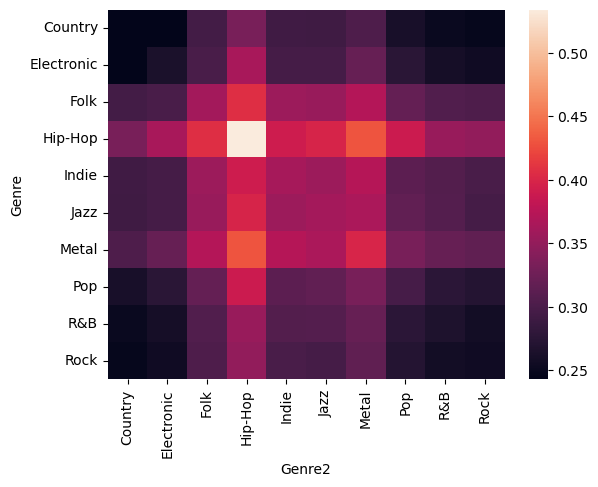

In [22]:
sns.heatmap(grouped_df.pivot(index="Genre", columns="Genre2", values="Similarity"))

#### Visualization (PCA) (visualizing LDA Results)

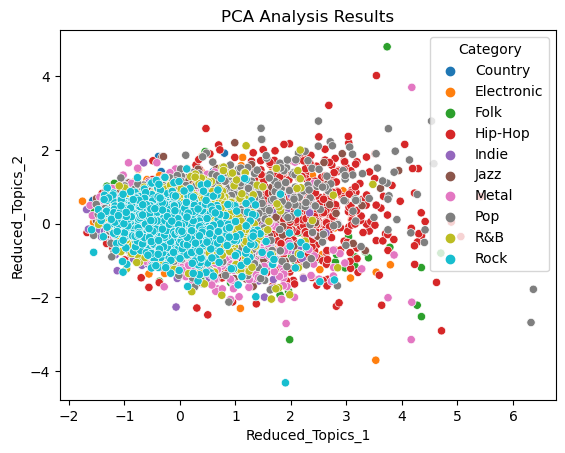

In [59]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, vector_size)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Using Clustering

In [60]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, vector_size)]])
results["Cluster"] = kmeans.labels_

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Genre,Lyrics,Tokens,CleanLyrics,0,1,2,3,4,5,...,493,494,495,496,497,498,499,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,goin girl writer bobby bond goin girl summerti...,"[goin, girl, writer, bobby, bond, goin, girl, ...",goin girl writer bobby bond goin girl summerti...,-0.021198,-0.017294,-0.039730,-0.005462,-0.007909,0.026111,...,-0.023903,0.026022,0.139046,0.010355,0.003079,0.023696,-0.013397,-1.065479,0.393733,1
1,Country,rather live life lies fantasy than face truth ...,"[rather, live, life, lies, fantasy, face, trut...",rather live life lies fantasy face truth reali...,-0.003684,0.053170,-0.012698,0.016713,0.013298,0.044082,...,-0.021674,-0.050101,-0.019222,-0.009254,-0.004774,-0.010871,0.015410,-1.248445,0.021153,1
2,Country,well making list st.nick tonight afraid what w...,"[well, making, list, st.nick, tonight, afraid,...",well making list st.nick tonight afraid want y...,-0.059486,0.003524,0.008590,-0.045957,-0.031767,0.013147,...,0.091981,0.090190,0.167559,-0.037653,0.054619,0.034899,0.072596,-1.159651,0.646522,1
3,Country,though gone away play your favorite song blue ...,"[though, gone, away, play, favorite, song, blu...",though gone away play favorite song blue gold ...,0.002668,-0.026555,0.044712,-0.026033,0.002764,-0.009576,...,0.003979,-0.019861,-0.039299,-0.001863,-0.083840,-0.015741,0.046904,-0.568163,-0.208745,3
4,Country,"daddy little girl writers bobby burke, horace ...","[daddy, little, girl, writers, bobby, burke,, ...","daddy little girl writers bobby burke, horace ...",0.052200,0.028235,0.097286,0.073931,-0.038036,-0.024704,...,-0.030706,0.032264,0.015610,0.017981,-0.151707,-0.067535,-0.010897,-0.007390,-0.021656,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,said couldn find anyone love said there more l...,"[said, find, anyone, love, said, life, broken,...",said find anyone love said life broken heart c...,-0.019070,0.053387,0.123962,0.050541,-0.047980,0.021324,...,-0.070774,-0.005294,-0.002134,-0.003844,-0.077768,0.008288,0.069505,-0.965885,0.306755,1
9996,Rock,caress inside bones caress inside bones house ...,"[caress, inside, bones, caress, inside, bones,...",caress inside bones caress inside bones house ...,0.004643,0.055134,-0.014410,-0.003719,0.006096,0.032299,...,-0.063380,-0.042118,0.031100,-0.035659,-0.155898,-0.089600,0.048786,-0.554951,-0.135720,3
9997,Rock,married fever hotter than pepper sprout been t...,"[married, fever, hotter, pepper, sprout, talki...",married fever hotter pepper sprout talkin bout...,0.107985,0.156885,0.225058,0.114829,-0.192426,-0.150975,...,0.139805,0.075043,0.153708,-0.046459,-0.003167,-0.154357,0.163827,0.425387,0.882047,9
9998,Rock,open your eyes life time flies open light back...,"[open, eyes, life, time, flies, open, light, b...",open eyes life time flies open light back open...,-0.020817,0.020155,0.062932,0.073981,-0.012257,-0.023951,...,0.030796,0.125091,-0.074312,0.037169,-0.077705,0.001194,-0.023729,-0.522216,0.084206,1


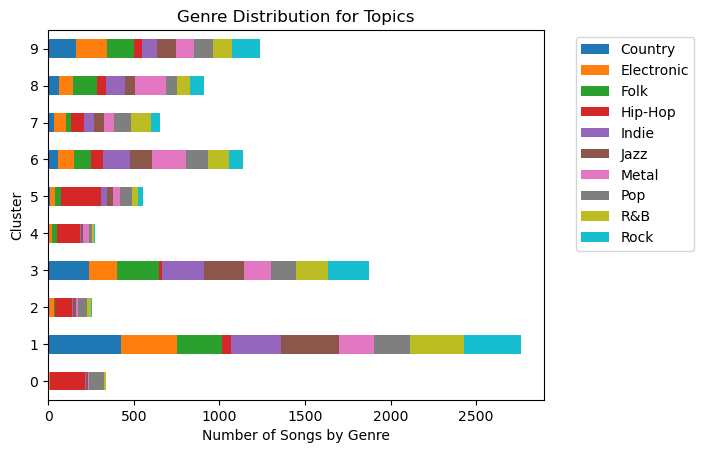

In [61]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

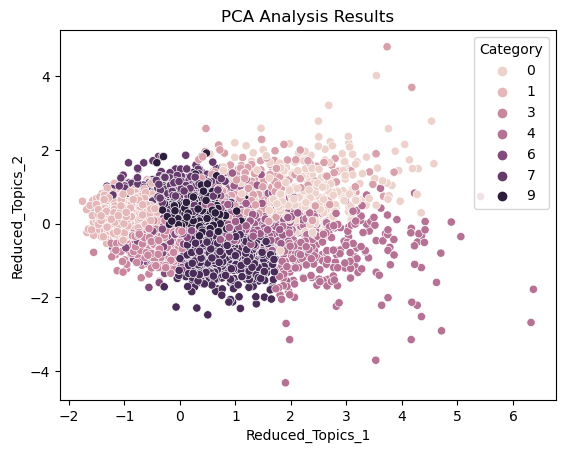

In [62]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [63]:
X = results[[i for i in range(0, vector_size)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [64]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.20833333333333334

In [65]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.25133333333333335

In [66]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.25666666666666665

### Get Classification Matrix (of knn)

In [67]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.22      0.46      0.29       318
           1       0.21      0.30      0.25       308
           2       0.19      0.15      0.16       288
           3       0.55      0.65      0.59       303
           4       0.23      0.18      0.20       320
           5       0.22      0.21      0.21       290
           6       0.28      0.29      0.29       292
           7       0.22      0.09      0.13       292
           8       0.11      0.03      0.05       324
           9       0.14      0.14      0.14       265

    accuracy                           0.25      3000
   macro avg       0.24      0.25      0.23      3000
weighted avg       0.24      0.25      0.23      3000



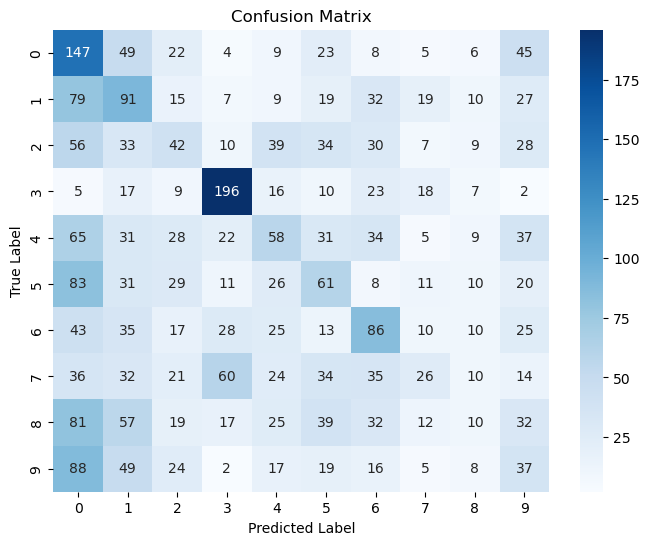

In [68]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = svc.classes_

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [69]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Erstellung eines doc2vec models basierend auf den tokenized lyrics
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 
- Überprüfung ob sich lieder gleicher genres im durchsschnitt ähnlicher sind als lieder unterschiedlicher genres

### Ergebnis
- schwerere interpretierbarkeit der Ergebnisse im vergleich zu den klassischen topic modeling methoden
- visualisierung als scatterplot zeigt keine offensichtlichen zusammenhänge
- clustering zeigt ähnliche ergebnisse wie bei lda, im bezug auf das cluster dass nur hiphop und pop enthält. das bezieht sich wahrscheinlich auf die klassischen ghetto hip-hop themen
- die ergebnisse sind insofern übereinstimmend mit den anderen methoden
- trotz der höheren dimensionalität keine besseren ergebnisse bei den klassifizierungsverfahren
- auch hier kann am besten HipHop vorhergesagt werden, gefolgt von country und metal
- Keine Aussage über die genauen themen der Genres möglich, deshalb ist die methode weniger geeignet als die anderen
- HipHop songs sind anderen HipHop songs im Durchschnitt ähnlicher